In [18]:
import pandas as pd
df_telematics = pd.read_csv('~/Development/data/root/Driver_Behavior.csv')
df_telematics

,speed_kmph,accel_x,accel_y,brake_pressure,steering_angle,throttle,lane_deviation,phone_usage,headway_distance,reaction_time,behavior_label
0,36.075011,0.535763,0.708633,23.107812,-3.169956,53.123505,0.851871,1,17.996005,1.400050,Distracted
1,38.090536,0.973764,0.044312,36.961137,-24.380082,36.383904,1.459495,1,29.904182,1.428537,Distracted
2,71.314445,3.638434,0.789375,79.734087,-6.100238,78.110507,0.254723,0,11.126012,0.406950,Aggressive
3,86.485997,2.441366,0.039135,45.007002,17.886191,82.794935,0.911664,0,11.064505,0.539964,Aggressive
4,52.816777,-0.201763,0.560619,38.759612,-4.104323,61.432375,1.591244,1,21.967570,1.369908,Distracted
...,...,...,...,...,...,...,...,...,...,...,...
29995,53.793871,0.630921,0.338402,26.264227,1.380436,32.252103,0.934973,1,27.011128,1.765279,Distracted
29996,47.963150,0.578964,0.073692,22.825827,9.846702,34.785630,0.255194,0,42.445077,0.710229,Safe
29997,49.804551,1.377664,0.546392,49.951452,7.958562,39.792856,0.524941,1,25.878929,1.449100,Distracted
29998,44.326306,0.421080,0.127109,0.738540,12.019311,29.867322,0.309540,0,41.039219,0.711371,Safe


# Dataset
It was synthetically generated, taken from kaggle [vehicle telemetry for driver behavior](https://www.kaggle.com/datasets/sonalshinde123/vehicle-telemetry-for-driver-behavior-analysis).
Originally the dataset has a target label, but we are going to remove it and explore the data without those labels.
The idea is to see if we can identify and clasify drivers behaviors based on their telemetry data.





In [19]:
import pandas as pd
df_telematics_analysis = df_telematics.drop(columns=['behavior_label'])

In [3]:
print(f"duplicated rows: {df_telematics_analysis.duplicated().sum()}")
df_telematics_analysis.info()

duplicated rows: 0
<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   speed_kmph        30000 non-null  float64
 1   accel_x           30000 non-null  float64
 2   accel_y           30000 non-null  float64
 3   brake_pressure    30000 non-null  float64
 4   steering_angle    30000 non-null  float64
 5   throttle          30000 non-null  float64
 6   lane_deviation    30000 non-null  float64
 7   phone_usage       30000 non-null  int64  
 8   headway_distance  30000 non-null  float64
 9   reaction_time     30000 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.3 MB


No duplicated values and everything is numeric, a good scenario for a **PCA**

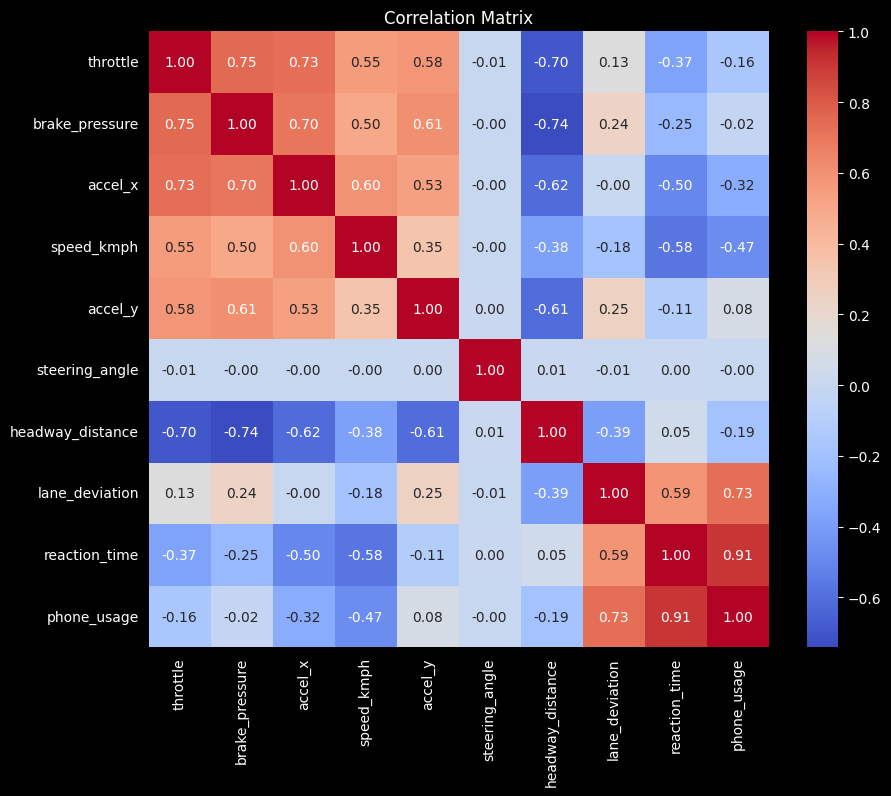

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
corr = df_telematics_analysis[[
    "throttle",
    "brake_pressure",
    "accel_x",
    "speed_kmph",
    "accel_y",
    "steering_angle",
    "headway_distance",
    "lane_deviation",
    "reaction_time",
    "phone_usage",

]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The `steering_angle` is **truly independant**, all correlations are very close to $0$.

Correlation between `phone_usage` and `reaction_time` if very high at $0.91$,
suggest that the **if the driver is on their phone, their reaction time will be slow**,
and if the reaction time is slow, it's very likely that the driver was on their phone.


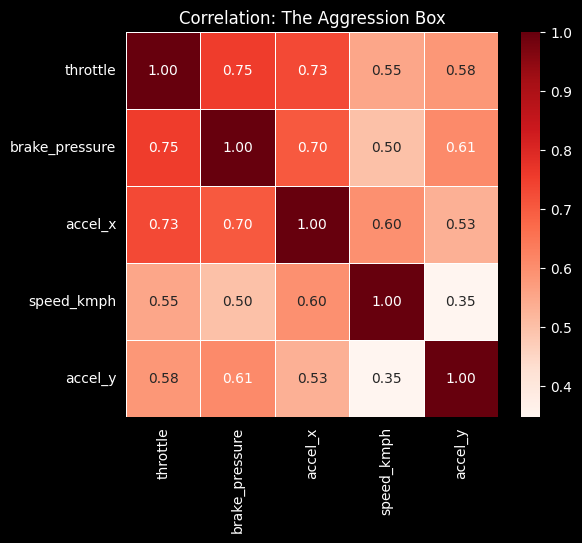

In [5]:
aggression_vars = [
    'throttle',
    'brake_pressure',
    'accel_x',
    'speed_kmph',
    'accel_y',
]

aggression_corr = df_telematics[aggression_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    aggression_corr,
    annot=True,
    cmap='Reds',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation: The Aggression Box")
plt.show()

Looking at the correlation of `accel_x`, `brake_pressure` and `throttle` we can infer that the "Agressive drivers" they **press the gas and jump straight to smashing the brake pedal** without "coasting." This seems like a classic signature of "tailgating," or speeding up to something, then panic breaking.

The `speed_kmph` has a lower correlation, indicating that the Aggresion behavior is more about force, because probably **we can find aggresive behavior not at high speeds**.

The difference on the correlation values between `accel_x` and `accel_y` with the other variables, tell us that the aggresive behavior is likely to happen in a **straight line reckless driving** rather than a drift king cornering behavior.

In [6]:
from statsmodels.multivariate.pca import PCA

pca_sm = PCA(df_telematics_analysis, standardize=True)

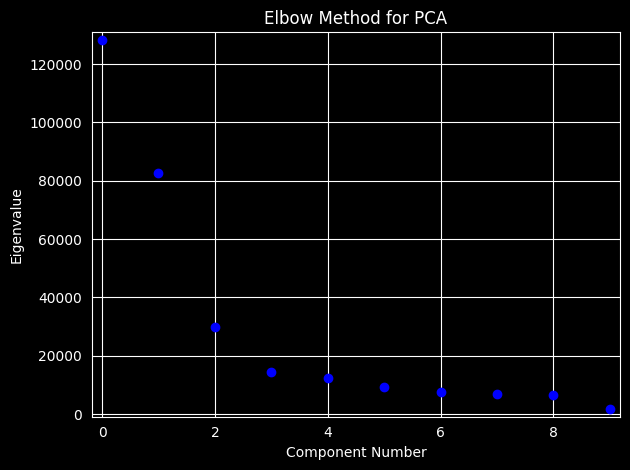

ncomp
0    0.000000
1    0.427785
2    0.703020
3    0.803028
4    0.851606
5    0.893346
Name: rsquare, dtype: float64


In [7]:
pca_sm.plot_scree(log_scale=False)
plt.title("Elbow Method for PCA")
plt.show()
print(pca_sm.rsquare[pca_sm.rsquare < 0.9])

The elbow method suggests two components explain 70% of the variance,
and three components explain 80%.

I think that **three components are more adequate**.

In [8]:
pca_3 = PCA(df_telematics_analysis, standardize=True, ncomp=3)

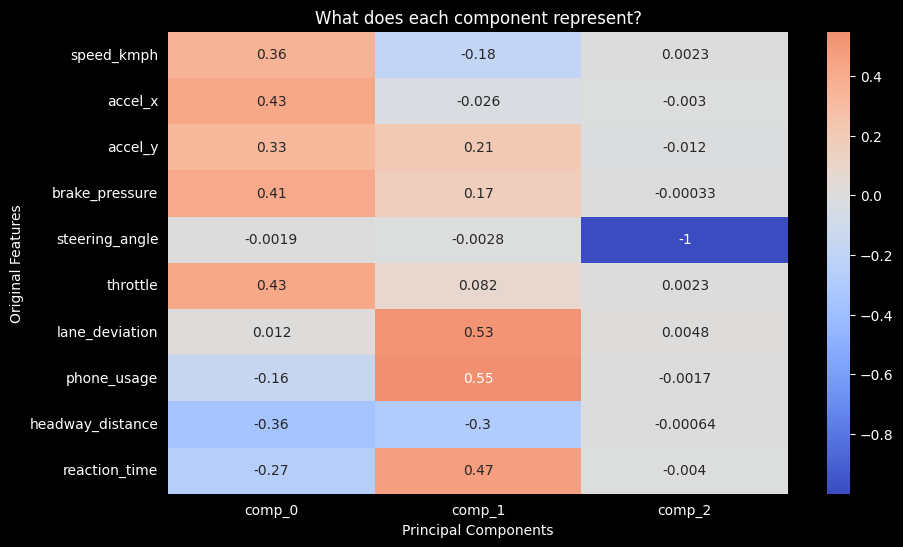

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(pca_3.loadings, annot=True, cmap='coolwarm', center=0)
plt.title("What does each component represent?")
plt.ylabel("Original Features")
plt.xlabel("Principal Components")
plt.show()

In [10]:
import plotly.express as px

df_vis = pca_3.factors.copy()
df_vis.columns = ['Aggression (PC1)', 'Distraction (PC2)', 'Steering (PC3)']

df_vis['Speed'] = df_telematics_analysis['speed_kmph']
df_vis['Phone'] = df_telematics_analysis['phone_usage']
df_vis['Brake'] = df_telematics_analysis['brake_pressure']

fig = px.scatter_3d(
    df_vis,
    x='Aggression (PC1)',
    y='Distraction (PC2)',
    z='Steering (PC3)',
    color='Aggression (PC1)',
    color_continuous_scale='Viridis',
    opacity=0.7,
    hover_data=['Speed', 'Phone', 'Brake'],
    title="3D Driver Behavior Analysis"
)

fig.update_traces(marker=dict(size=3))
from pathlib import Path

out = Path("charts/interactive scatter.html")
fig.write_html(out, include_plotlyjs="cdn")


### 3D Driver Behavior Analysis
Click the image below to explore the interactive 3D visualization:

[![3D PCA Scatter Plot](./charts/scatter%20prev.png)](https://miguebarbell.github.io/telematics/charts/interactive%20scatter.html)

In [11]:
import plotly.express as px

df_vis = df_telematics_analysis.copy()
df_vis['Aggression'] = pca_3.factors.iloc[:, 0]
df_vis['Distraction'] = pca_3.factors.iloc[:, 1]

fig = px.parallel_coordinates(
    df_vis,
    dimensions=['speed_kmph', 'brake_pressure', 'phone_usage', 'Aggression', 'Distraction'],
    color="Aggression",
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="How Raw Driving Data Flows into PCA Scores"
)

out = Path("charts/interactive flow chart.html")
fig.write_html(out, include_plotlyjs="cdn")


### 3D Driver Behavior Analysis
Click the image below to explore the interactive 3D visualization:

[![3D PCA Flow Chart](./charts/flow%20chart%20prev.png)](https://miguebarbell.github.io/telematics/charts/interactive%20flow%20chart.html)

with three components we can see a separation between those three.
## PC1 (Aggresive)
highs:
- `throttle`
- `brake_pressure`
- `accel_x`
lows:
- `headway_distance`
## PC2 (Distracted)
highs:
- `lane_deviation`
- `phone_usage`
- `reaction_time`
## PC3 (Chill)
lows:
- `steering_angle`

Why does the **PC3** have the lowest steering_angle value?

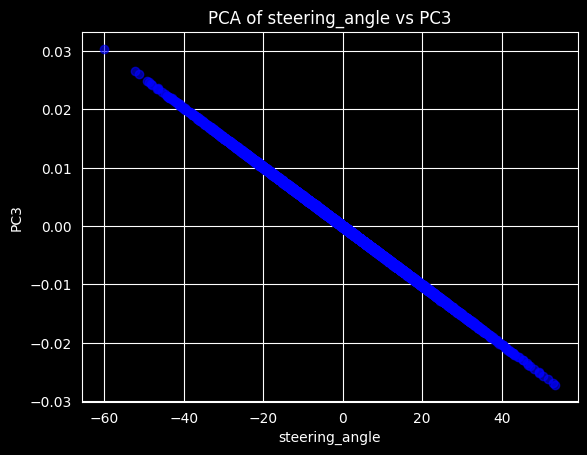

In [12]:
pca_3_values = pca_3.factors.iloc[:, 2]
plt.scatter(df_telematics_analysis['steering_angle'], pca_3_values, alpha=0.6, color='blue')
plt.xlabel('steering_angle')
plt.ylabel('PC3')
plt.title('PCA of steering_angle vs PC3')
plt.show()

The fact that we have a perfect line in the relationship between the `steering_angle` and the **PC3**,
means that this is the only behavior that can be grouped on this component.


We assume that steering doesn't define anything on the other two Principal Components,
it could not be grouped on those components.

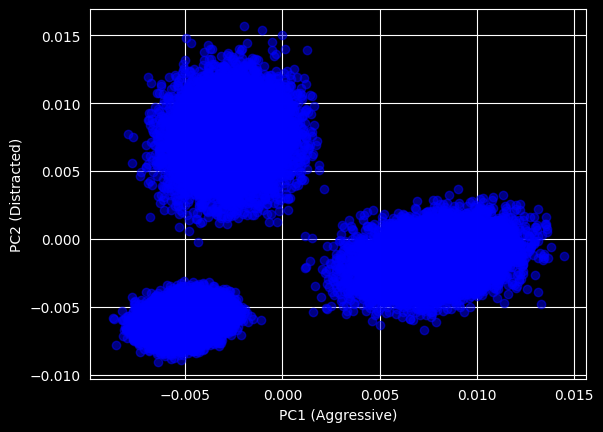

In [13]:
plt.scatter(
    pca_3.factors.iloc[:, 0],
    pca_3.factors.iloc[:, 1],
    alpha=0.5,
    color='blue'
)
plt.xlabel("PC1 (Aggressive)")
plt.ylabel("PC2 (Distracted)")
plt.show()

## right side (High Aggression, Low Distraction)
that represents the Aggressive drivers,
they have higher values on the PC1.
## top left (High Distraction, Low Aggression)
that represents the distracted drivers,
they have higher values on the PC2.
## bottom left
the Safe-Chill behavior,
where they don't have any high value on the PC1 or PC2 components.

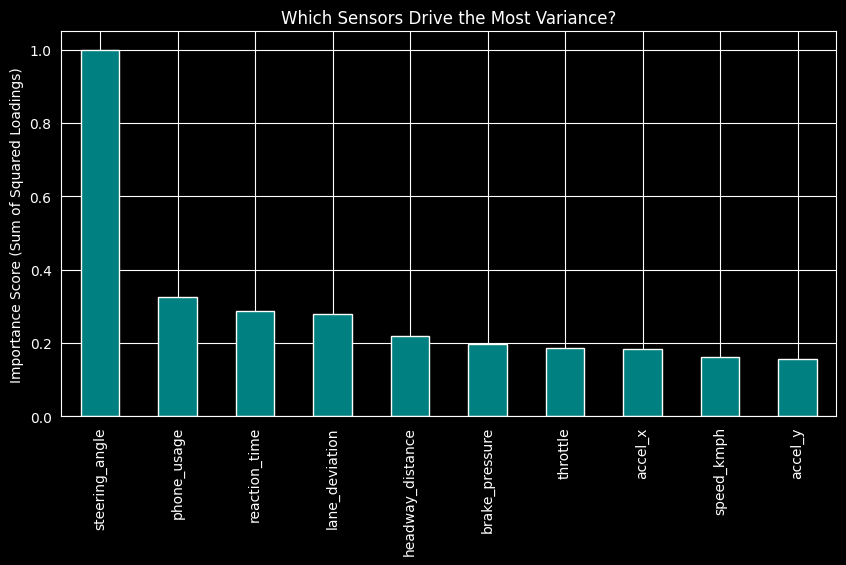

In [14]:
importance = (pca_3.loadings ** 2).sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
importance.plot(kind='bar', color='teal')
plt.title("Which Sensors Drive the Most Variance?")
plt.ylabel("Importance Score (Sum of Squared Loadings)")
plt.show()

if we can afford only 2 sensors for detecting distracted behavior,
we should choose `phone_usage` and `reaction_time`.
if we repeat the same exersice for detecting aggresive behavior,
we should choose `breal_pressure` and `throttle`.

# Prediction
For this part we are going to do create a pipeline using scikit-learn

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

seed = 42

X = df_telematics.drop(columns=['behavior_label'])
y = df_telematics['behavior_label']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('clusterer', KMeans(n_clusters=3, random_state=seed))
])

pipeline.fit(X)
y_pred_clusters = pipeline.predict(X)


In [16]:
from sklearn.metrics import adjusted_rand_score, homogeneity_score

ari_score = adjusted_rand_score(y, y_pred_clusters)
homogeneity = homogeneity_score(y, y_pred_clusters)

print(f"Adjusted Rand Score: {ari_score:.2f}")
print(f"Homogeneity Score:   {homogeneity:.2f}")


Adjusted Rand Score: 1.00
Homogeneity Score:   1.00


We achieved an Adjusted Rand Score of $1.00$. This indicates a perfect alignment between our unsupervised cluster and the ground truth.

It confirms that the driver behaviors (Safe, Aggressive and Distracted) are **linearly separable in the PCA space**, and our pipeline can autonomously indentify these profiles.

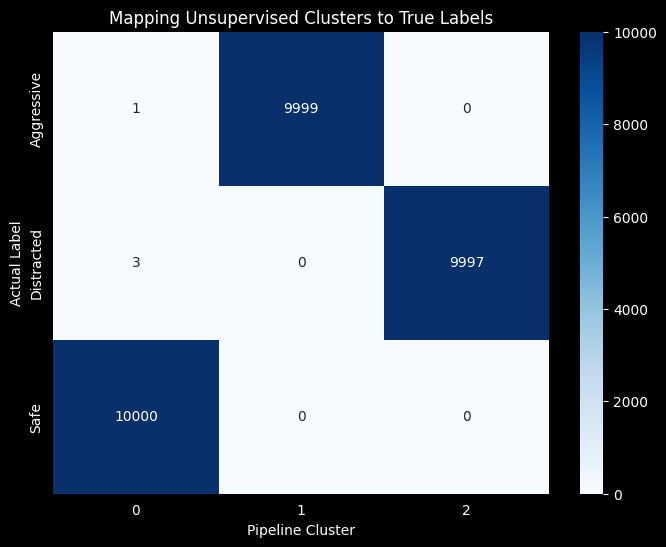

In [17]:
confusion_df = pd.crosstab(
    y,
    y_pred_clusters,
    rownames=['Actual Label'],
    colnames=['Pipeline Cluster']
)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title("Mapping Unsupervised Clusters to True Labels")
plt.show()